In [1]:
import torch
import numpy as np
import h5py
from load_brats_all_modalities import load_data
import matplotlib.pyplot as plt

In [60]:
data_dir = '/srv/Data/playground_data/brats/brats_training_data/data_raw'
h5_path = '/srv/Data/playground_data/brats/h5_all_modalities'


In [25]:
dataset = load_data(brats_path=data_dir,h5_path=h5_path)
loader = torch.utils.data.DataLoader(dataset,batch_size = 1,shuffle = True ,num_workers= 1)

In [55]:
for idx,image in enumerate(loader):
    t1 = np.asarray(image['t1'].squeeze())
    t2 = np.asarray(image['t2'].squeeze())
    t1ce= np.asarray(image['t1ce'].squeeze())
    flair = np.asarray(image['flair'].squeeze())
    seg = np.asarray(image['seg'].squeeze())
    break

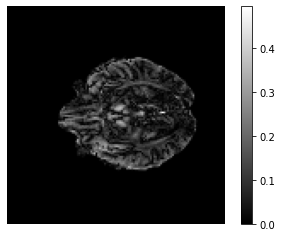

In [56]:
x = np.concatenate((t1,t2,t1ce,flair,seg),axis=1)
plt.imshow(abs(flair-t1),cmap='gray')
plt.axis('off')
plt.colorbar()

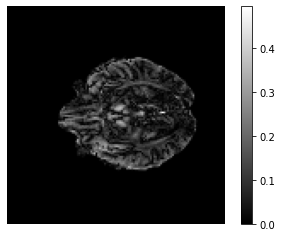

In [58]:
plt.imshow(abs(t1-flair),cmap='gray')
plt.axis('off')
plt.colorbar()

In [59]:
# h5 = '/srv/Data/playground_data/brats/h5_all_modalities/12.h5'
# data={}
# with h5py.File(h5,'r',libver='latest', swmr=True) as itm:
#         for key in itm.keys():                       
#             data[key]=torch.from_numpy(itm[key][:,:,:,100])

## Prostate

In [6]:
from load_prostate import SliceData
import numpy as np
import matplotlib.pyplot as plt

import torch
def normalize(x):
    return x-x.min()/(x.max()-x.min())

In [24]:
from torch.utils.data import DataLoader
root = '/srv/Data/playground_data/prostate/'
data = SliceData(root,mode='train')
loader = DataLoader(data,batch_size = 1, shuffle = True,num_workers=0)

In [25]:
for i,img in enumerate(loader):
    batch,_ = img
    break

(-0.5, 639.5, 127.5, -0.5)

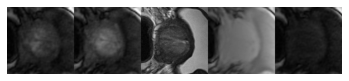

In [27]:
x_t = batch[:,3:,:,:]
y = np.concatenate((x_t.numpy(),batch[:,0:3,:,:].numpy()),axis=1)
x = np.concatenate((y[0,0],y[0,1],y[0,2],y[0,3],y[0,4]),axis=1)
plt.imshow(x,cmap='gray')
plt.axis('off')

(-0.5, 767.5, 127.5, -0.5)

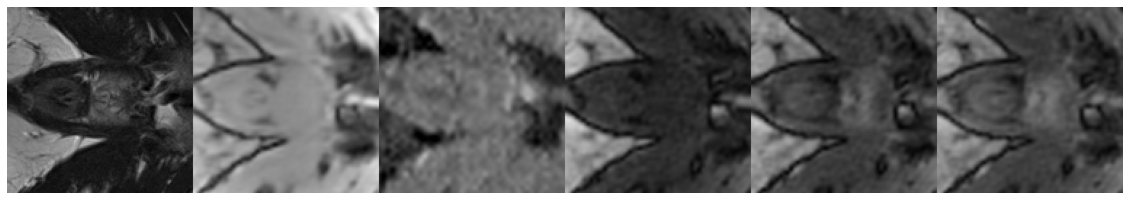

In [16]:
batch_np = batch.numpy()[2].squeeze()
x = np.concatenate((batch_np[0],batch_np[1],batch_np[2],batch_np[3],batch_np[4],batch_np[5]),axis=1)
plt.figure(figsize=(20,20))
plt.imshow(x,cmap='gray')
plt.axis('off')

## IXI

In [1]:
import torch
import matplotlib.pyplot as plt
import glob

data_path = '/srv/Data/playground_data/ixi_data/ixi'
h5_path = '/srv/Data/playground_data/ixi_data/h5_ixi'

In [2]:
import os
import glob
import numpy as np
import torch
from tqdm.notebook import tqdm
from monai.data import ITKReader,NibabelReader
from monai.transforms import LoadImage, LoadImaged
from monai.transforms import (
    Orientationd, AddChanneld, Compose, ToTensord, Spacingd,Resized,ScaleIntensityD,ResizeWithPadOrCropd,Rotate90
)
from monai.data import Dataset
import h5py
import threading


def load_data(ixi_path,h5_path):
    ixi_path = ixi_path + '/**_Guys/T2/NIfTI/**'
    transforms_1 = Compose(
    [
     AddChanneld(('image')),
     Orientationd(('image'),'RAS'),
     ScaleIntensityD(('image',)),
     ToTensord(('image')),
    ])
    
    dataset = H5CachedDataset(ixi_path,transforms_1,h5cachedir=h5_path)

    return dataset

class H5CachedDataset(Dataset):
    def __init__(self, datapath,
                 transforms_1, 
                 nslices_per_image = 130 ,
                 start_slice = 60,
                 end_slice = 45,
                 h5cachedir=None):

        if h5cachedir is not None:
            if not os.path.exists(h5cachedir):
                os.mkdir(h5cachedir)
            self.cachedir = h5cachedir
        niilist=[]
        for x in glob.glob(datapath):
            niilist.append(x)

        self.datalist = niilist

        self.xfms = transforms_1
                    
        #### 3d image loader from monai
        
        self.loader = LoadImage()
        self.loader.register(NibabelReader())
        
        #### start_slice & end_slice---> slices to be truncated in each volume vol[:,:,start_slice:-end_slice]
        
        self.start_slice = start_slice
        self.end_slice = end_slice
        
        self.nslices = nslices_per_image - self.end_slice

        
    def __len__(self):
        #### total number of slices in all the volumes
        return len(self.datalist)*(self.nslices - self.start_slice)
    
    def clear_cache(self):
        #### function to clear the directory storing h5 files (used for caching the h5 files)
        for fn in os.listdir(self.cachedir):
            os.remove(self.cachedir+'/'+fn)
            
    def __getitem__(self,index):
        #### ditionary to store data slicewise
        data = {}
        label ={}
#      
#        
        filenum = index // (self.nslices - self.start_slice)


        slicenum = index % (self.nslices - self.start_slice)

        slicenum += self.start_slice
        
        #### Extract the datafile location & mask file location based on filenum

        datalist_filenum = self.datalist[filenum]

        loc_data = datalist_filenum

            
        ##### if h5 exists for the current volume fill data dictionary with current slice number
        if self.cachedir is not None:
            h5name = self.cachedir+'/%d.h5' % filenum

            ptname = self.cachedir+'/%d.pt' % filenum

            if os.path.exists(h5name):
                
                with h5py.File(h5name,'r',libver='latest', swmr=True) as itm:
                    for key in itm.keys():                       
                        data[key]=torch.from_numpy(itm[key][:,:,:,slicenum])



        ##### if data dictionary is empty #######
        if len(data)==0:
            
            imgdata, meta = self.loader(loc_data)

            ### Rotating it ###
            imgdata = torch.rot90(imgdata,3)
            
            #### store volume wise image & mask data,metadata in a dictionary 
            data_i = {'image':imgdata}

            #### transform the data dictionary
            data3d = self.xfms(data_i)

            if self.cachedir is not None:
                other = {}

                with h5py.File(h5name,'w',libver='latest') as itm:
                    itm.swmr_mode = True
                    for key in data3d:
                        if key in ['image']:                             
                            img_npy = data3d[key].numpy()

                            shp = img_npy.shape
                            
                            chunk_size = list(shp[:-1])+[1]
                            ds = itm.create_dataset(key,shp,chunks=tuple(chunk_size),dtype=img_npy.dtype)
                            ds[:]=img_npy[:]
                            ds.flush()
                    else:
                        other[key]=data3d[key]
                torch.save(other,ptname)
                
            data = {'image':data3d['image'][:,:,:,slicenum]}

            
        if len(data)>0:

            res = data
            res['filenum'] = filenum
            res['slicenum'] = slicenum
            res['idx'] = index
            return res['image'] , {"y":np.array((1))}

        else:
            # replace with random
            return self.__getitem__(np.random.randint(len(self.datalist)))


In [4]:
cls = load_data(data_path,h5_path)

In [15]:
loader = torch.utils.data.DataLoader(cls,batch_size = 10,\
                                              shuffle = True ,num_workers= 1)

In [16]:
for idx,image in enumerate(loader):
    print(image[0].shape)


torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size

torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size

torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])
torch.Size

In [17]:
image[0].shape

torch.Size([5, 1, 256, 256])

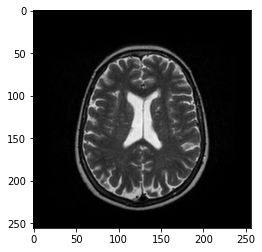

In [19]:
plt.imshow(image[0][,0,:,:],cmap = 'gray')

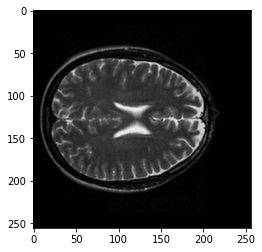

In [12]:
###### Original image #########
import nibabel as nib
import matplotlib.pyplot as plt
pa = '/srv/Data/playground_data/ixi_data/ixi/422_Guys/T2/NIfTI/IXI422-Guys-1071-T2.nii.gz'
img = nib.load(pa).get_fdata()
slice = 80

plt.imshow(img[:,:,slice],cmap = "gray")

In [145]:
img.shape

(128, 128, 56)

In [7]:
# plt.imshow(x[0][0,:,:],cmap = 'gray') #### original
import glob
path = '/srv/Data/playground_data/ixi_data/ixi/**_Guys/PD/NIfTI/IXI422-Guys-1071-PD.nii.gz'
x = glob.glob()

In [9]:
300*25

7500